
## About this Notebook

This notebook has been prepared for teaching activities and student support in the framework of the [**Passion in Action Artificial Intelligence for the Earth: Geospatial Foundation Models**](https://www.polimi.it/en/corsi/passion-in-action/detail/artificial-intelligence-for-the-earth-geospatial-foundation-models) course at Politecnico di Milano.

Its purpose is to showcase and provide tools for downloading image chips of satellite imagery based on provided ground-truth point data. The workflows presented here aim to support students in their project development by offering practical examples and reusable code.

The notebook has been adapted from the [*geemap package*](https://geemap.org/) and tutorials on image chip extraction originally developed by Qiusheng Wu ([https://joss.theoj.org/papers/10.21105/joss.02305](https://joss.theoj.org/papers/10.21105/joss.02305)), with modifications to suit the specific needs of this course.


Tutors / Contributors: Vasil Yordanov(vasil.yordanov@polimi.it) and Julia Anna Leonardi (juliaanna.leonardi@polimi.it).



In [1]:
#!pip -q install retry pycrs leafmap

In [ ]:
import geopandas as gpd
import leafmap.foliumap as leafmap
import ee, geemap, pycrs
import logging
import multiprocessing
import os, requests, shutil, csv
from retry import retry
import matplotlib.pyplot as plt
import pandas as pd
import math

Mount your google Drive to the project to save the data generated in your storage. A pop-up window will appear to grant GDrive access to the notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The first time you run the following cell a pop-up window will appear and ask you to allow third-party access - **approve it**!

In [ ]:
###### GEE Authentication ######
ee.Authenticate()
gee_project_name = 'YOUR-GEE-PROJECT-ID' # paste here your Cloud Project ID
ee.Initialize(project=gee_project_name, opt_url="https://earthengine-highvolume.googleapis.com")

# Define input

**IMPORTANT:** To be able to use the notebook you would need a valid Google Earth Engine account ([https://earthengine.google.com/](https://earthengine.google.com/)) and project ID. To register yourself go to the webpage and select *Get started* button and follow the instructions. Once you are registered, you can access the interface from the [code editor](https://code.earthengine.google.com/) and from the upper-right you can click on your profile file, select *Project info* and copy the id under *Cloud Project* (you will need it in the next cell).

## 🟢 Define parameters


In [ ]:
##### Pointa Data #####
# You can provide your ground-truth data eithers as SHP, GPKG or GEE feature collection

# load the data points as Feature Collection from GEE
# for GeoFM course - do not change the path to the dataset
lucas_points = ee.FeatureCollection('users/vyordanov/workshops/PiA_GeoFM/lucas')
legend_dict = {'1': 'Arable land',
               '2': 'Permanent crops',
               '3': 'Grass',
               '4': 'Wooded areas',
               '5': 'Shrubs',
               '6': 'Bare surface, low or rare vegetation',
               '7': 'Artificial constructions and sealed areas',
               '8': 'Inland water',
               '9': 'Transitional and Coastal Water',
               '10': 'Impossible to PI'}

# uncomment if you will provide SHP, GPKG
# points_file = '/content/LUCAS-Master.gpkg' #put an url to the Lucas points vector
# # read gpd lucas points
# lucas_points = gpd.read_file(points_file)


##### Case Study #####
# Select your country
country_code = 'IT'
country = 'Italy'


###### Sampling ######
sampling_type = "proportional"    # "equal" or "proportional", else == "random"
n_per_class = 10                # used if sampling_type == "equal"
total_n = 100                     # used if sampling_type == "proportional"
n_random = 100                    # fallback option


###### GEE Image ######
gee_image_collection = "NASA/HLS/HLSS30/v002" # dataset id from GEE data catalogue
gee_start_date = '2018-01-01'
gee_end_date = '2019-01-01'
IC_property = 'CLOUD_COVERAGE' # cloud property name may vary for different datasets
cloud_cover_value = 10
list_of_bands = ['B4', 'B3', 'B2','B8', 'B11', 'B12']
# IMPORTANT: if you are using Sentinel-2 uncomment and run the Sentinel-2 cells


##### Chip Setup ######
dimensions = 224  # The dimension of each image chip
format = "GEO_TIFF"  # The output image format, can be png, jpg, ZIPPED_GEO_TIFF, GEO_TIFF, NPY
# prefix = "Chip_"  # The filename prefix

out_dir = "/content/drive/MyDrive/GEE/Lucas" # path to output directory

##🟢 Apply the selected filtering approach

### 🟢 Run the cell below if you are using GEE feature collection as original data source

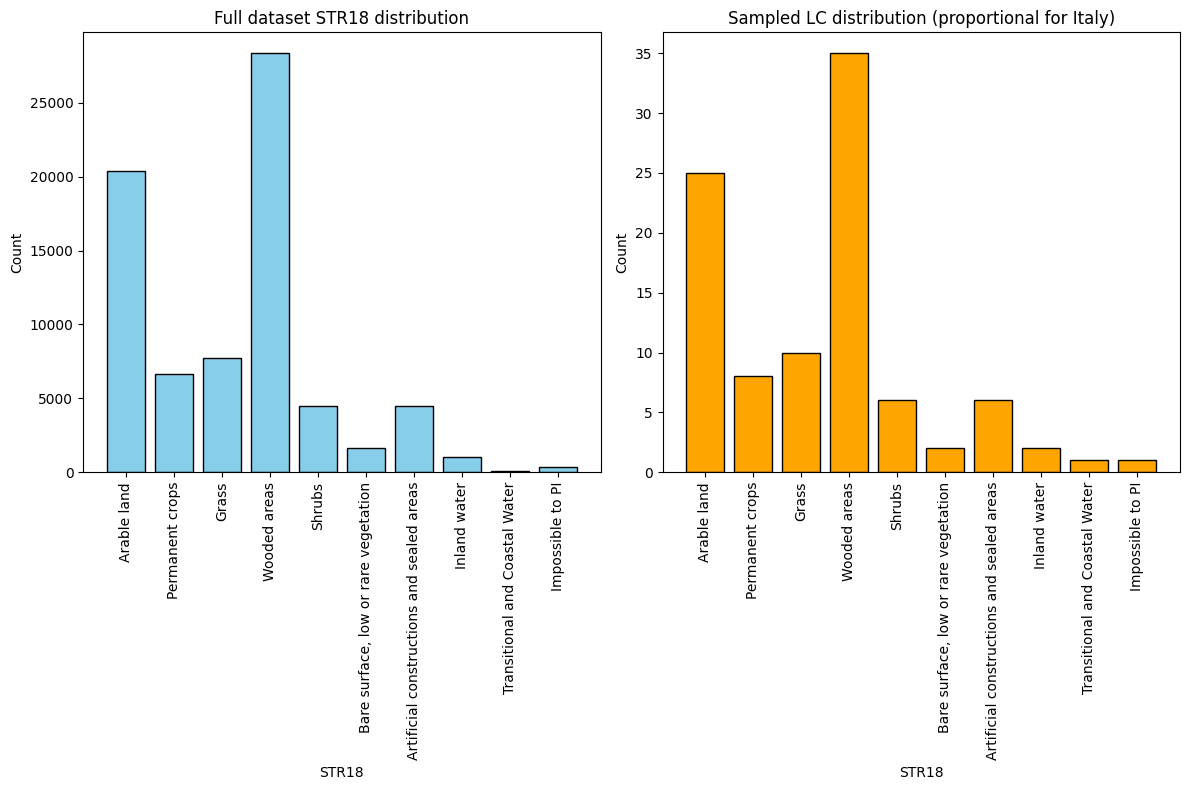

Total points in sample: 96


In [ ]:
# Filter the points for your country
lucas_points_NUTS = lucas_points.filter(ee.Filter.eq("NUTS0_16", country_code))

##### Sampling approach ####
if sampling_type == "equal":
    classes = lucas_points_NUTS.aggregate_array("STR18").distinct().getInfo()
    samples_list = []
    for cls in classes:
        subset = lucas_points_NUTS.filter(ee.Filter.eq("STR18", cls))
        count = subset.size().getInfo()
        n = min(count, n_per_class)
        if n > 0:
            # random selection
            subset = subset.randomColumn("rand").sort("rand").limit(n)
            samples_list.append(subset)
    lucas_points_sample = ee.FeatureCollection(samples_list).flatten()

elif sampling_type == "proportional":
    class_counts = lucas_points_NUTS.aggregate_histogram("STR18").getInfo()
    total_count = sum(class_counts.values())
    proportions = {k: v / total_count for k, v in class_counts.items()}

    # Apply normalization
    alpha = 0.01
    all_classes = class_counts.keys()
    smoothed_props = {cls: proportions.get(cls, 0) + alpha for cls in all_classes}
    total_smoothed = sum(smoothed_props.values())
    norm_props = {cls: smoothed_props[cls] / total_smoothed for cls in smoothed_props}

    # Compute initial sample counts
    initial_counts = {}
    for cls in all_classes:
        # basic proportional count
        n = int(math.floor(norm_props[cls] * total_n))
        # guarantee at least 1 sample if the class has points
        if n == 0 and class_counts[cls] > 0:
            n = 1
        # cannot exceed available points
        n = min(n, class_counts[cls])
        initial_counts[cls] = n

    samples_list = []
    for cls, count in class_counts.items():
        n = initial_counts[cls]
        if n > 0:
            subset = lucas_points_NUTS.filter(ee.Filter.eq("STR18", int(cls)))
            subset = subset.randomColumn("rand").sort("rand").limit(n)
            samples_list.append(subset)
    lucas_points_sample = ee.FeatureCollection(samples_list).flatten()



else:
    # Fallback: random sample
    sampling_type = "random"
    lucas_points_sample = (
        lucas_points_NUTS.randomColumn("rand").sort("rand").limit(n_random)
    )

##### HISTOGRAMS ####
# Full dataset distribution
hist_full = lucas_points_NUTS.aggregate_histogram("STR18").getInfo()
# Sampled dataset distribution
hist_sample = lucas_points_sample.aggregate_histogram("STR18").getInfo()

# Sort by class label (for consistent x-axis)
classes_sorted = sorted(set(hist_full.keys()) | set(hist_sample.keys()), key=int)
classes_sorted_labels = [legend_dict[str(c)] for c in classes_sorted]

# Convert to lists
full_counts = [hist_full.get(c, 0) for c in classes_sorted]
sample_counts = [hist_sample.get(c, 0) for c in classes_sorted]

# #### PLOT ####
fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=False)

axes[0].bar(classes_sorted, full_counts, color="skyblue", edgecolor="black")
axes[0].set_title("Full dataset STR18 distribution")
axes[0].set_xticks(classes_sorted)
axes[0].set_xticklabels(classes_sorted_labels, rotation=90)
axes[0].set_xlabel("STR18")
axes[0].set_ylabel("Count")

axes[1].bar(classes_sorted, sample_counts, color="orange", edgecolor="black")
axes[1].set_title(f"Sampled LC distribution ({sampling_type} for {country})")
axes[1].set_xticks(classes_sorted)
axes[1].set_xticklabels(classes_sorted_labels, rotation=90)
axes[1].set_xlabel("STR18")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

print("Total points in sample:", lucas_points_sample.size().getInfo())


### 🟠 Run the cell below if you are using SHP, GPKG as original data source

In [ ]:
# # select points according to 'NUTS0_16' column value
# lucas_points_NUTS = lucas_points[lucas_points['NUTS0_16'] == country_code]

# # apply equal or proportional sampling
# if sampling_type == "equal":
#     # equal number of samples from each category
#     lucas_points_sample = (
#         lucas_points_NUTS.groupby('STR18', group_keys=False)
#         .apply(lambda x: x.sample(min(len(x), n_per_class)))
#     )

# elif sampling_type == "proportional":
#     # proportional to class distribution, with total_n points
#     class_counts = lucas_points_NUTS['STR18'].value_counts()
#     proportions = class_counts / class_counts.sum()
#     samples_per_class = (proportions * total_n).round().astype(int)

#     # adjust rounding
#     diff = total_n - samples_per_class.sum()
#     if diff != 0:
#         for i in range(abs(diff)):
#             idx = samples_per_class.idxmax() if diff > 0 else samples_per_class.idxmin()
#             samples_per_class[idx] += 1 if diff > 0 else -1

#     # draw samples class by class
#     samples_list = []
#     for cls, n in samples_per_class.items():
#         n = min(n, (lucas_points_NUTS['STR18'] == cls).sum())  # avoid oversampling
#         if n > 0:
#             samples_list.append(
#                 lucas_points_NUTS[lucas_points_NUTS['STR18'] == cls].sample(n)
#             )
#     lucas_points_sample = pd.concat(samples_list)

# else:
#     # fallback: random sample of fixed size
#     lucas_points_sample = lucas_points_NUTS.sample(n_random)

# # #### HISTOGRAM COMPARISON ####
# fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)  # <- no shared y-axis

# # Full dataset distribution
# lucas_points_NUTS['STR18'].value_counts().sort_index().plot(
#     kind="bar", ax=axes[0], color="skyblue", edgecolor="black"
# )
# axes[0].set_title("Full dataset STR18 distribution")
# axes[0].set_xlabel("STR18")
# axes[0].set_ylabel("Count")

# # Sampled dataset distribution
# lucas_points_sample['STR18'].value_counts().sort_index().plot(
#     kind="bar", ax=axes[1], color="orange", edgecolor="black"
# )
# axes[1].set_title(f"Sampled STR18 distribution ({sampling_type})")
# axes[1].set_xlabel("STR18")
# axes[1].set_ylabel("Count")

# plt.tight_layout()
# plt.show()

# print(f'Total points: {len(lucas_points_sample)}')

# GEE points to tiles

## 🟢 Data filtering according to administrative boundaries


In [ ]:
# define map
Map = geemap.Map()

# add the Global Administrative Unit Layers (GAUL) dataset from GEE data catalogue
gaul = ee.FeatureCollection('FAO/GAUL/2015/level1')

# select country
country_bound = gaul.filter(ee.Filter.eq('ADM0_NAME', country))

#compute the bounding box from country
bbox = country_bound.geometry().bounds()

## 🟠Uncomment and run the cell below **only** if you are using Sentinel-2 imagery

In [ ]:
# uncomment and run below to define maskS2clouds
# only if you are using Sentinel-2 imagery

# def maskS2clouds(image):
#     qa = image.select('QA60')

#     # Bits 10 and 11 are clouds and cirrus, respectively. Value 1 means presence of cloud and cirrus
#     cloudBitMask = 1 << 10
#     cirrusBitMask = 1 << 11

#     # Both flags should be set to zero, indicating clear conditions.
#     mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
#     .And(qa.bitwiseAnd(cirrusBitMask).eq(0))
#     return image.updateMask(mask).divide(10000)

## 🟢 Image selection

In [ ]:
collection = (ee.ImageCollection(gee_image_collection)
                  .filterDate(gee_start_date, gee_end_date)
                  .filterBounds(country_bound)
                  .filter(ee.Filter.lt(IC_property, cloud_cover_value))
                  .select(list_of_bands)
                #   .map(maskS2clouds) #uncomment only if you are using Sentinel-2
)

original_proj = collection.first().projection();
crs = collection.first().projection().crs().getInfo()
scale = original_proj.nominalScale().getInfo()
# print(original_proj.nominalScale().getInfo())

image = collection.median().clip(bbox)#.setDefaultProjection(original_proj)

visPar = {
  "min": 0.01, # values for HLS, change accordingly if different
  "max": 0.18, # values for HLS, change accordingly if different
  "bands": ['B4', 'B3', 'B2'], # change if you are using different from Sentinel-2 or HLS
};

## 🟠 Uncomment and run the cell below only if you have provided SHP, GPKG as the original data source

In [ ]:
# path_to_shp = '/content/lucas_points_sample.shp' # change the path to your file

# # convert to shapefile
# lucas_points_sample.to_file(path_to_shp)

# # load the points shapefile
# lucas_shp = path_to_shp
# points = geemap.shp_to_ee(lucas_shp)
# Map.addLayer(points, {}, "Countries")

## 🟢 Visualize the map canvas

In [ ]:
# add the satellite image to the map
Map.addLayer(image.clip(country_bound), visPar, 'Image',0);

# add the country boundaries to the map
Map.centerObject(country_bound,6)
Map.addLayer(country_bound, {}, "Area of Interest",0)

# add the filtered points to the map
Map.addLayer(lucas_points_sample, {}, "Lucas points",0)

# NB: Sometimes the image might be not entirely rendered on the canvas,
# it is only visualization issue, the chips will be exported properly.
Map

Map(center=[42.70753570476074, 12.20577502563997], controls=(WidgetControl(options=['position', 'transparent_b…

## 🟢 Set chip parameters

If you want the exported images to have coordinate system, change `format` to `GEO_TIFF`. Otherwise, you can use `png` or `jpg` formats.

**IMPORTANT:** each time the cell is ran it will delete your GDrive folder and create it again.
If you do not want to be delete comment out line 11.

In [ ]:
params = {
    "count": lucas_points_sample.size(),  # n chips to export (use len() in case of SHP, GPKG)
    "buffer": (dimensions/2)*scale,  # The buffer distance (m) around each point
    "dimensions": f'{dimensions}x{dimensions}',  # The dimension of each image chip
    "format": format,  # The output image format, can be png, jpg, ZIPPED_GEO_TIFF, GEO_TIFF, NPY
    # "prefix": prefix,  # The filename prefix
    "processes": 25,  # How many processes to used for parallel processing
    "out_dir": out_dir,  # The output directory. Default to the current working directly
}

!rm -rf "{params['out_dir']}" # deletes the folder
for key in legend_dict.keys():
    !mkdir -p "{params['out_dir']}/{key}" #creates the folders

## 🟢 Create functions for downloading image

The `getResult()` function then takes one of those points and generates an image centered on that location, which is then downloaded as a PNG and saved to a file. This function uses `image.getThumbURL()` to select the pixels, however you could also use `image.getDownloadURL()` if you wanted the output to be in GeoTIFF or NumPy format ([source](https://gorelick.medium.com/fast-er-downloads-a2abd512aa26)).


In [ ]:
def getRequests():
    return lucas_points_sample.aggregate_array(".geo").getInfo()


@retry(tries=10, delay=1, backoff=2)
def getResult(index, point):
    point = ee.Geometry.Point(point["coordinates"])
    region = point.buffer(params["buffer"]).bounds()

    if params["format"] in ["png", "jpg"]:
        url = image.getThumbURL(
            {
                "region": region,
                "dimensions": params["dimensions"],
                "format": params["format"],
            }
        )
    else:
        url = image.getDownloadURL(
            {
                "region": region,
                "dimensions": params["dimensions"],
                "format": params["format"],
            }
        )

    if params["format"] == "GEO_TIFF":
        ext = "tif"
    else:
        ext = params["format"]

    r = requests.get(url, stream=True)
    if r.status_code != 200:
        r.raise_for_status()
    # print(url)
    out_dir = os.path.abspath(params["out_dir"])
    # basename = str(index).zfill(len(str(params["count"])))
    # filename = f"{out_dir}/{params['prefix']}{basename}.{ext}"
    basename = str(point_ids[index])
    lc_folder = str(str18_values[index])
    filename = f"{out_dir}/{lc_folder}/{basename}.{ext}"
    with open(filename, "wb") as out_file:
        shutil.copyfileobj(r.raw, out_file)
    print("Done: ", basename)

# 🟢 Run the whole process to download the image chips

## This might take approx 20 minutes - don't disconnect from the runtime and wait until all the chips will be created. In case of problems contact one of the lecturers.


In [ ]:
%%time
logging.basicConfig()
items = getRequests()

# get STR18 and POINT_ID values once
str18_values = lucas_points_sample.aggregate_array("STR18").getInfo()
point_ids    = lucas_points_sample.aggregate_array("POINT_ID").getInfo()

results_list = []

pool = multiprocessing.Pool(params["processes"])
for i, point in enumerate(items):
    getResult(i, point)
    chip_name = str(point_ids[i])  # use POINT_ID as chip name
    results_list.append([chip_name, str18_values[i]])
pool.close()

# write to CSV
csv_path = os.path.join(params["out_dir"], "chips_LC_class.csv")
with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Point_ID", "STR18"])
    writer.writerows(results_list)

print(f"CSV saved to {csv_path}")


Done:  45922254
Done:  49621950
Done:  44782128
Done:  44942370
Done:  42381944
Done:  44022206
Done:  42201832
Done:  45282562
Done:  42682412
Done:  41881786
Done:  46382198
Done:  42202480
Done:  41402372
Done:  43022460
Done:  42641940
Done:  44682164
Done:  47822048
Done:  45102234
Done:  41822394
Done:  45702078
Done:  49441792
Done:  45422248
Done:  43422396
Done:  48641738
Done:  43742412
Done:  44902292
Done:  48102110
Done:  47142114
Done:  50181946
Done:  49721980
Done:  41442434
Done:  41082406
Done:  46242058
Done:  48841862
Done:  47541634
Done:  44662326
Done:  42201934
Done:  41422534
Done:  46182146
Done:  41002530
Done:  44062644
Done:  40862366
Done:  40942384
Done:  46022542
Done:  46622062
Done:  47241664
Done:  42881892
Done:  46362070
Done:  42182368
Done:  44422324
Done:  43982612
Done:  42221970
Done:  43522322
Done:  42601832
Done:  46342156
Done:  44922570
Done:  47421980
Done:  42701912
Done:  43682222
Done:  45722534
Done:  44722136
Done:  44222356
Done:  4

# **🚀 Now you have a small fine-tuning dataset sitting in your Google Drive (.\GEE\Lucas\) that you can use for scene classification in the final project of this course!**